In [2]:
import time
import ua_generator
from ua_generator.options import Options as uaOptions
from ua_generator.data.version import VersionRange

from datetime import datetime
from typing import List
from threading import Thread

from ixbrowser_local_api import IXBrowserClient
import pyotp
from peewee import *
import sqlite3
import tkinter as tk
from Crypto.Random import random


from selenium_stealth import stealth

from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.remote.webelement import WebElement
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import ElementClickInterceptedException, NoSuchElementException, TimeoutException, ElementClickInterceptedException

# Setup

## ixBrowser

In [2]:
ixClient = IXBrowserClient(port=54200)

In [3]:
data = ixClient.get_profile_list()
item = data[0]
profile_id = item['profile_id']
open_result = ixClient.open_profile(profile_id, cookies_backup=False, load_profile_info_page=False)

In [4]:
data = ixClient.get_profile_list()
if data is None:
    print(time.strftime("%H:%M:%S", time.localtime(time.time())), 'Get profile list error:')
    print(time.strftime("%H:%M:%S", time.localtime(time.time())), 'Error code=', ixClient.code)
    print(time.strftime("%H:%M:%S", time.localtime(time.time())), 'Error message=', ixClient.message)

if len(data) == 0:
    print(time.strftime("%H:%M:%S", time.localtime(time.time())), 'Please create a profile first.')

item = data[0]

profile_id = item['profile_id']
print(time.strftime("%H:%M:%S", time.localtime(time.time())), 'profile_id=', profile_id)

open_result = ixClient.open_profile(profile_id, cookies_backup=False, load_profile_info_page=False)
if open_result is None:
    print(time.strftime("%H:%M:%S", time.localtime(time.time())), 'Open profile error:')
    print(time.strftime("%H:%M:%S", time.localtime(time.time())), 'Error code=', ixClient.code)
    print(time.strftime("%H:%M:%S", time.localtime(time.time())), 'Error message=', ixClient.message)

web_driver_path = open_result['webdriver']
debugging_address = open_result['debugging_address']

22:33:12 profile_id= 2


## Chrome

In [1]:
options = uaOptions()
options.weighted_versions = True
options.version_ranges = {
    'chrome': VersionRange(125, 129),  # Choose version between 125 and 129
    'edge': VersionRange(min_version=120),  # Choose version 120 minimum
}
ua = ua_generator.generate(platform=('linux', 'windows', 'windows'), device='desktop', browser=('chrome', 'firefox'), options=options)

ua.text

NameError: name 'uaOptions' is not defined

In [6]:

# Enabling weighted versions

chrome_options = Options()

chrome_service = Service(executable_path="/usr/bin/chromedriver")
# chrome_service = Service(executable_path=web_driver_path)
# chrome_service = Service(executable_path=web_driver_path.replace('\\\\', '\\'))

# chrome_options.add_experimental_option("debuggerAddress", debugging_address)
chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
chrome_options.add_experimental_option("useAutomationExtension", False)

chrome_options.add_argument(f"user-agent={ua.text}")
chrome_options.add_argument('--disable-blink-features=AutomationControlled')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument("--enable-logging")
chrome_options.add_argument("--disable-blink-features")
chrome_options.add_argument("--disable-blink-features=AutomationControlled")

driver = Chrome(service=chrome_service, options=chrome_options)
# driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
#     "source": """
#         Object.defineProperty(navigator, 'webdriver', {
#             get: () => undefined
#         });
#     """
# })

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
)



driver.maximize_window()
# changing the property of the navigator value for webdriver to undefined 
driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})") 
driver.execute_cdp_cmd('Network.enable', {})

{}

## SQLite3

In [33]:
sqlite_db = SqliteDatabase('database.db', pragmas={'journal_mode': 'wal'})

In [ ]:
class BaseModel(Model):
    """A base model that will use our Sqlite database."""
    class Meta:
        database = sqlite_db


class Transactions(BaseModel):
    id = PrimaryKeyField()
    created_at = DateTimeField(default=datetime.now)
    end_of_deal = DateTimeField()
    bybit_account_id = CharField(null=False)
    bybit_account_email = CharField(null=False, max_length=70)
    bybit_account_username = CharField(null=False, max_length=20)
    bybit_transaction_id = BigIntegerField(null=False)
    bybit_transaction_type = CharField(null=False, max_length=20)
    bybit_trader_username = CharField(null=False)
    bybit_trader_purchase_price = FloatField(null=False)
    
    payeer_transaction_id = BigIntegerField(null=False)


## TKinter

In [24]:
paused = False
stopped = False

def scraper():
    """
    Ваш основной процесс парсера.
    """
    global paused, stopped
    while not stopped:
        if paused:
            print("Парсер на паузе...")
            time.sleep(1)
            continue
        print("Парсер работает...")
        time.sleep(2)  # Симуляция работы

def toggle_pause():
    """
    Управление паузой.
    """
    global paused
    paused = not paused
    status_label.config(text="Статус: Пауза" if paused else "Статус: Работает")

def stop_scraper():
    """
    Остановка парсера.
    """
    global stopped
    stopped = True
    root.destroy()  # Закрыть окно управления

# Настройка GUI
root = tk.Tk()
root.title("Управление парсером")

status_label = tk.Label(root, text="Статус: Работает")
status_label.pack(pady=10)

pause_button = tk.Button(root, text="Пауза/Возобновить", command=toggle_pause)
pause_button.pack(pady=5)

stop_button = tk.Button(root, text="Остановить", command=stop_scraper)
stop_button.pack(pady=5)

# Запуск парсера в отдельном потоке
scraper_thread = Thread(target=scraper, daemon=True)
scraper_thread.start()

# Запуск интерфейса
root.mainloop()


Парсер работает...
Парсер работает...
Парсер работает...
Парсер работает...
Парсер работает...
Парсер работает...
Парсер работает...
Парсер на паузе...
Парсер на паузе...
Парсер работает...
Парсер работает...
Парсер на паузе...
Парсер на паузе...
Парсер на паузе...


# Extra functions

In [8]:
def type_like_human(element, text):
    for char in text:
        element.send_keys(char)
        time.sleep(random.uniform(0.05, 0.2))
        
def scroll_page(driver):
    scroll_height = driver.execute_script("return document.body.scrollHeight")
    for i in range(0, scroll_height, random.randint(100, 300)):
        driver.execute_script(f"window.scrollTo(0, {i});")
        time.sleep(random.uniform(0.2, 1.0))

def handle_warning_popup(driver):
    """Handle potential warning pop-up and click 'Confirm'."""
    try:
        confirm_button = WebDriverWait(driver, 2).until(
            EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'ant-btn-primary')]//span[text()='Confirm']"))
        )
        confirm_button.click()
        print("Warning pop-up handled successfully.")
    except (NoSuchElementException, TimeoutException):
        pass
    except Exception as e:
        print(f"An error occurred while handling the pop-up: {e}")

def get_page_numbers(driver):
    """Retrieve the available page numbers from the pagination."""
    try:
        page_elements = WebDriverWait(driver, 5).until(
            EC.presence_of_all_elements_located((By.XPATH, "//div[@class='trade-table__pagination']//li[contains(@class, 'pagination-item')]"))
        )
        return [int(elem.text) for elem in page_elements if elem.text.isdigit()]
    except TimeoutException:
        print("Timeout while waiting for pagination elements.")
        return []

def pass_totp(totp_fields: List[WebElement]): 
    totp = list(pyotp.TOTP("OYAMBQTXZXMEXACY").now())
    for i, field in enumerate(totp_fields):
        time.sleep(0.5)
        field.send_keys(totp[i])

In [9]:
driver.get("https://www.bybit.com/en/login")

In [14]:
driver.get("https://payeer.com/en/auth/")

driver.find_element(By.XPATH, "//form//input[attribute::name='email']").send_keys("P1127815005")
driver.find_element(By.XPATH, "//form//input[attribute::name='password']").send_keys("3XkmZ77z")

time.sleep(0.9)
driver.find_element(By.XPATH, "//button[contains(@class, 'login-form__login-btn')]").click()

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//form//input[attribute::name='email']"}
  (Session info: chrome=131.0.6778.264); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
#0 0x57d4143451fa <unknown>
#1 0x57d413e55810 <unknown>
#2 0x57d413ea4506 <unknown>
#3 0x57d413ea47a1 <unknown>
#4 0x57d413ee9c24 <unknown>
#5 0x57d413ec85ad <unknown>
#6 0x57d413ee7007 <unknown>
#7 0x57d413ec8323 <unknown>
#8 0x57d413e96de0 <unknown>
#9 0x57d413e97dbe <unknown>
#10 0x57d41431112b <unknown>
#11 0x57d4143150c7 <unknown>
#12 0x57d4142fe6cc <unknown>
#13 0x57d414315c47 <unknown>
#14 0x57d4142e367f <unknown>
#15 0x57d414334288 <unknown>
#16 0x57d414334450 <unknown>
#17 0x57d414344076 <unknown>
#18 0x753111d3239d <unknown>
#19 0x753111db749c <unknown>


# Bypass topt


In [31]:

# print(driver.execute_script("return document.querySelectorAll('input[name~=\\'email\\']'), document.querySelectorAll('input[name~=\\'email\\']')")[0].get_attribute('value'))
print(driver.execute_script("return document.querySelectorAll('input[name~=\\'email\\']'), document.querySelectorAll('input[name~=\\'email\\']')"))

[<selenium.webdriver.remote.webelement.WebElement (session="3281764b2c6e610a3b41d0635d9121e0", element="f.231FF51A739D34245D59CECE586218A3.d.121CF44C00E79BDE0FCDE68AC00B0B7B.e.1726")>]


In [5]:

script = """
document.querySelector("button[class~='by-button-continue']").addEventListener('click', function(event) {
    event.preventDefault();  // Останавливаем стандартное действие кнопки

    // Получаем значения из инпутов

     

    // Возвращаем данные в скрипт через Selenium
    window.dataFromInputs = { input1: document.querySelector("input[name~='email']").value, input2: document.querySelector("input[name~='password']").value};

    // Программно нажимаем на кнопку (если нужно продолжить стандартное действие)
    // event.target.click();
});
"""

# Выполняем скрипт в контексте страницы
driver.execute_script(script)


# # Ожидание ввода данных и нажатия кнопки
# print("Ожидаю ввода данных и нажатия кнопки подтверждения...")
while True:
    # Проверяем, были ли заполнены данные
    try: 
        driver.find_element(By.XPATH, "//div[contains(@class, 'security-component-modal')]//div[contains(text(), 'Security')]")
    except NoSuchElementException:
        continue

    data = driver.execute_script("return window.dataFromInputs || null;")
    if data:
        break
    time.sleep(1)  # Ждём, пока пользователь не нажмёт кнопку

# Достаём значения из данных
input1 = data['input1']
input2 = data['input2']

print(f"Считанные значения: input1={input1}, input2={input2}")

Считанные значения: input1=v8858539@gmail.com, input2=Stasvolk123


In [47]:
data

In [5]:
totp = list(pyotp.TOTP("OYA******CY").now())
print(pyotp.TOTP("OYA******CY").now())

782884


<html lang="en" style="background:var(--cht-gray-bg-page)" dir="ltr" class="webpok avifok" _platform="pc"><head><meta http-equiv="origin-trial" content="A/kargTFyk8MR5ueravczef/wIlTkbVk1qXQesp39nV+xNECPdLBVeYffxrM8TmZT6RArWGQVCJ0LRivD7glcAUAAACQeyJvcmlnaW4iOiJodHRwczovL2dvb2dsZS5jb206NDQzIiwiZmVhdHVyZSI6IkRpc2FibGVUaGlyZFBhcnR5U3RvcmFnZVBhcnRpdGlvbmluZzIiLCJleHBpcnkiOjE3NDIzNDIzOTksImlzU3ViZG9tYWluIjp0cnVlLCJpc1RoaXJkUGFydHkiOnRydWV9"><style data-rc-order="prepend" rc-util-key="@ant-design-icons">
.anticon {
  display: inline-block;
  color: inherit;
  font-style: normal;
  line-height: 0;
  text-align: center;
  text-transform: none;
  vertical-align: -0.125em;
  text-rendering: optimizeLegibility;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

.anticon > * {
  line-height: 1;
}

.anticon svg {
  display: inline-block;
}

.anticon::before {
  display: none;
}

.anticon .anticon-icon {
  display: block;
}

.anticon[tabindex] {
  cursor: pointer;
}

.ant
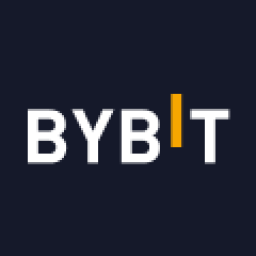
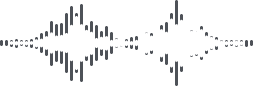
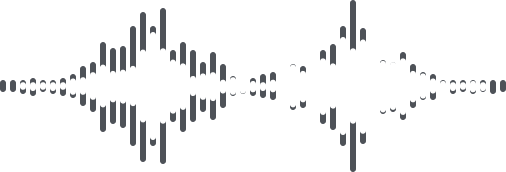
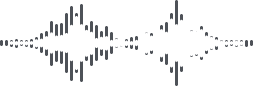
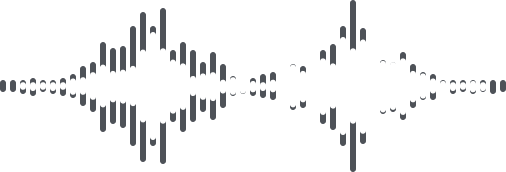
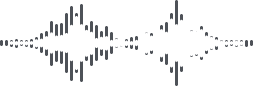
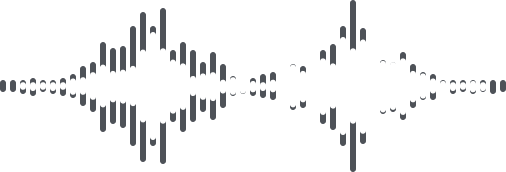
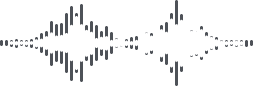
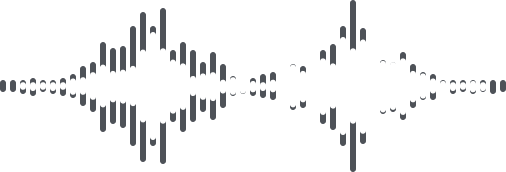

In [6]:
totp_fields = driver.find_elements(By.CLASS_NAME, "by-safety-verification-input-wrapper-box")
pass_totp(totp_fields)
print(driver.page_source)

# Trading

In [48]:
hover = ActionChains(driver).move_to_element(driver.find_element(By.CLASS_NAME, "user-profile"))
hover.perform()
print(driver.find_element(By.XPATH, "//p[contains(@class, 'user_info_id')]").text)

UID: 392804181


In [14]:
BYBIT_P2P_URL = "https://www.bybit.com/en/fiat/trade/otc/sell/USDT/RUB"
a = driver.get(BYBIT_P2P_URL)
handle_warning_popup(driver)

## Setup conditions

In [ ]:
condition_setup = False
while not condition_setup:
    try:
        # Open list of payments
        driver.find_element(By.XPATH, "//div[contains(@class, 'paywayAnchorList')]//ancestor::div[@class='by-popover__el']").click()

        time.sleep(0.5)

        # Choose payment method
        a = driver.find_element(By.XPATH, "//ul[@id='lists']//span[@title='Payeer']//ancestor::li")
        a.click()

        # Confirm choose
        btn = driver.find_element(By.XPATH, "//div[@id='paywayList']//button[contains(@class, 'btn-confirm')]")
        btn.click()

        # Wait for load
        time.sleep(1.5)
        # Set amount 
        driver.find_element(By.XPATH, "//input[(attribute::placeholder = 'Enter Amount' or attribute::placeholder='Введите сумму') and contains(@class, 'fiat-otc-input')]").send_keys(700)

        condition_setup = True
    except ElementClickInterceptedException:
        driver.find_element(By.TAG_NAME, "body").send_keys(Keys.CONTROL + Keys.HOME)
        
    except Exception as e:
        print(e)

Message: no such element: Unable to locate element: {"method":"xpath","selector":"//ul[@id='lists']//span[@title='Payeer']//ancestor::li"}
  (Session info: chrome=131.0.6778.264); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
#0 0x62ef0a8d41fa <unknown>
#1 0x62ef0a3e4810 <unknown>
#2 0x62ef0a433506 <unknown>
#3 0x62ef0a4337a1 <unknown>
#4 0x62ef0a478c24 <unknown>
#5 0x62ef0a4575ad <unknown>
#6 0x62ef0a476007 <unknown>
#7 0x62ef0a457323 <unknown>
#8 0x62ef0a425de0 <unknown>
#9 0x62ef0a426dbe <unknown>
#10 0x62ef0a8a012b <unknown>
#11 0x62ef0a8a40c7 <unknown>
#12 0x62ef0a88d6cc <unknown>
#13 0x62ef0a8a4c47 <unknown>
#14 0x62ef0a87267f <unknown>
#15 0x62ef0a8c3288 <unknown>
#16 0x62ef0a8c3450 <unknown>
#17 0x62ef0a8d3076 <unknown>
#18 0x7b688321139d <unknown>
#19 0x7b688329649c <unknown>



## Trade selection

advertiser-name  
advertiser-info         
execute-rates           
moly-text               
price-amount            
price-unit              
ql-value                
trade-list-tag          
trade-list-action-button

In [15]:
trades_detail = {}
trades = driver.find_elements(By.XPATH, "//tbody[@class='trade-table__tbody']//tr")

# Deleted trades that do not meet account criteria
for i in trades:
    if i.find_element(By.CLASS_NAME, 'trade-list-action-button').find_element(By.TAG_NAME, 'button').text == 'ineligible':
        trades.remove(i)
        continue

    trades_detail[i] = {
        "name": i.find_element(By.CLASS_NAME, "advertiser-name").text,
        "price": i.find_element(By.CLASS_NAME, "price-amount").text
    }

trades[0].find_element(By.CLASS_NAME, 'trade-list-action-button').find_element(By.TAG_NAME, 'button').click()

In [ ]:
total_pages = get_page_numbers(driver)[-1]

for i in range(random.randint(1, len(trades_detail))):
    pass



## Sell currency

In [37]:
sell_input = driver.find_element(By.CLASS_NAME, 'order-create-modal__form-wrapper').find_elements(By.CLASS_NAME, 'order-create-modal__input')[0].find_element(By.TAG_NAME, 'input')
sell_input.send_keys(500)

In [ ]:
driver.find_element(By.XPATH, "//div[@class='order-create-modal__button-content']//button//span[text() = 'Buy']").click()
handle_warning_popup(driver)

In [ ]:
# id="fiat-otc-order__payment-btn"
# index_paymentValue__i6xhe
# order-id-and-time
# im-container-caption__info-nickname
# class="summary-left"
# class="summary-item-value pay buy"
# class="summary-item-value buy"
# summary-item-value buy

In [ ]:
selector = driver.find_element(By.CLASS_NAME,'by-select-adv-selection-placeholder')

driver.execute_script("arguments[0].setAttribute('class', 'by-select-adv-selection-item')", selector)


js = """
var node = document.createElement("div");
g = document.createElement('div');
g.setAttribute("id", "Div1");
var textnode = document.createTextNode("Example");
node.appendChild(textnode);
document.getElementById("someIDOnPage").appendChild(node);  
"""
driver.execute_script(js)



# driver.execute_script("arguments[0].classList.('css-u8kubd-checked')", i)

# f"""
#              <div class="{payment_account_class}">
#               <div class=""></div>
#               <div class="{payment_pan_calss}">
#                 {pan} 
#               </div>
#             </div> 
# """

# Buy currency

In [ ]:
driver.refresh()

In [ ]:


a = driver.find_element(By.CLASS_NAME, "clip__items--checkbox").find_elements(By.CLASS_NAME, "ring-btn-default")
for i in a:
    try:
        i.click()
        driver.execute_script("arguments[0].classList.add('css-u8kubd-checked')", i)
    except ElementClickInterceptedException as e:
        continue
    except Exception as e:
        print(e)

    

In [28]:
driver.find_element(By.XPATH, "//span[@class='by-select-adv-selection-search']").click()

In [29]:
driver.find_element(By.XPATH, "//div[contains(@class, 'PaymentSelect_orderPaymentOption')]//div[text() = 'Payeer']").click()
# PaymentSelect_orderPaymentOption__7V-Kz

# Sandbox

In [ ]:
get_page_numbers(driver)

[1, 2, 3, 4, 5, 12]
